Problem Set 3

Problem 1 - Linear Least Squares

paramter  0  has value  -1512.3219644082942  and error  0.29794605227225407
paramter  1  has value  0.00043331584237056705  and error  0.0001194566823879032
paramter  2  has value  0.00016637255518015518  and error  7.869757218549207e-08
paramter  3  has value  -0.019406547149939717  and error  0.00011387223719209368
paramter  4  has value  0.00016701073181334667  and error  7.640282153322084e-08

The parameter values as [a,x0,y0,z0] are
[0.00016669164349675093, 1.3022455593753264, -58.099700957028084, -1512.8860038431199]

The error in a is 7.755019685935646e-08

The calculated focal length is, 1499.7752422116641
with an error of 0.6977426272755574


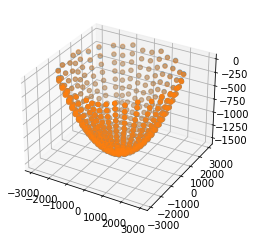

In [52]:
import numpy as np
from matplotlib import pyplot as plt 
from mpl_toolkits import mplot3d

data=np.loadtxt("dish_zenith.txt")
x=data[:,0]
y=data[:,1]
z=data[:,2]

A=np.zeros([len(x),5])
A[:,0]=1
A[:,1]=x
A[:,2]=x**2
A[:,3]=y
A[:,4]=y**2

fit=np.linalg.inv(A.T@A)@(A.T@z)
pred=A@fit

rms=np.std(z-pred)
N=rms**2
chisq=np.sum((z-pred)**2)/N**2

Ninv=np.eye(len(z))/N
lhs=A.T@Ninv@A
errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
for i in range(len(fit)):
    print('paramter ',i,' has value ',fit[i],' and error ',errs[i])

pred_cov=A@(np.linalg.inv(lhs)@A.T) #predicted N for data!

#Check fit visually
fig1=plt.figure(1)
ax=plt.axes(projection='3d')
ax.scatter3D(x,y,z)
ax.scatter3D(x,y,pred)

#Return to original parameters
orig_pars=[np.mean((fit[2],fit[4])),fit[1]/(2*fit[2]),fit[3]/(2*fit[4]),(fit[0]-fit[1]**2/(4*fit[2])-fit[3]**2/(4*fit[4]))]
print('\nThe parameter values as [a,x0,y0,z0] are')
print(orig_pars)

#Error in a
error_a=np.mean((errs[2],errs[4]))
print('\nThe error in a is',error_a)

#Focal Length f=1/(4a)
f=1/(4*orig_pars[0])
print('\nThe calculated focal length is,', f)

error_f=error_a/(4*orig_pars[0]**2)
print('with an error of',error_f)




![alt text](P3_1calc.png)

Problem 2 - Calculating Chi Squared

The chi squared value for this fit is, 1588.2376532931526


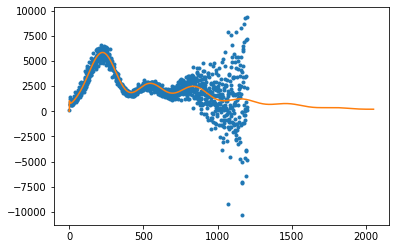

In [2]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=2000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]   
    return tt


plt.ion()

pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
plt.plot(wmap[:,0],wmap[:,1],'.')

cmb=get_spectrum(pars)
plt.plot(cmb)

chisq=np.sum((wmap[:,1]-cmb[2:1201])**2/(wmap[:,2])**2) #compare fit to data that we have, remove monopole and dipole terms

print('The chi squared value for this fit is,',chisq)


Problem 3 - Newton's Method/LM

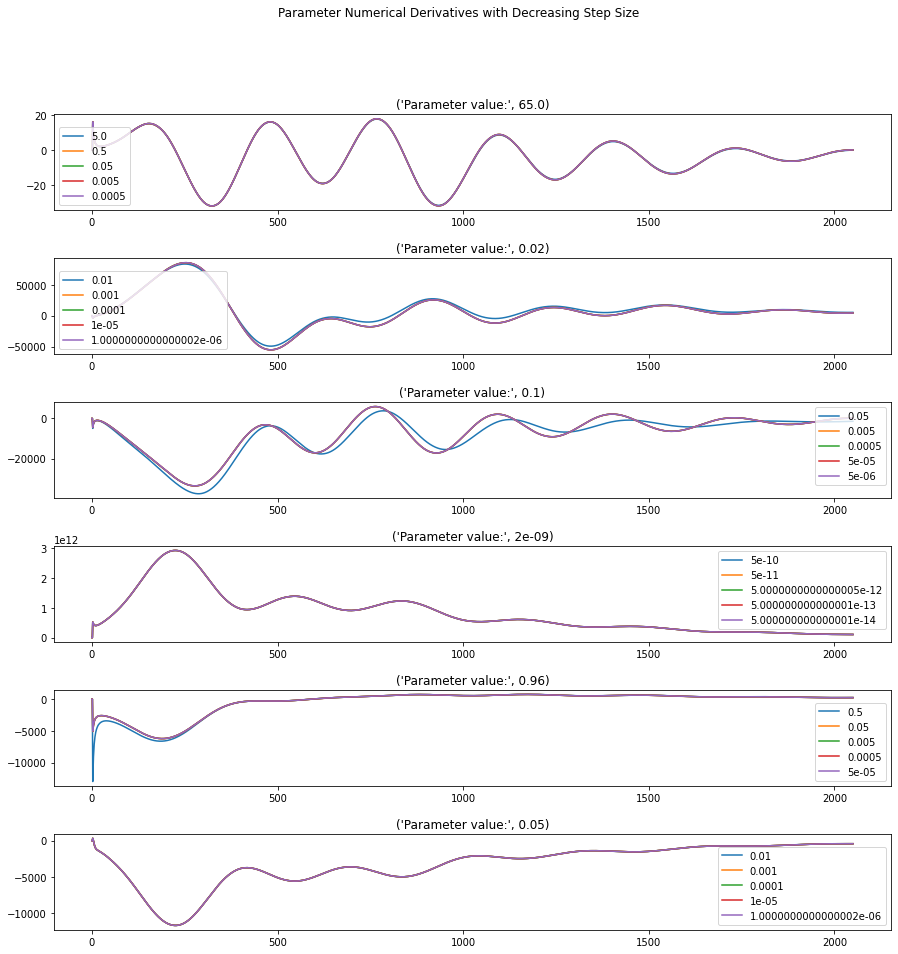


Change in chi squared at iteration 0 is -343.23422345754716

Change in chi squared at iteration 1 is 11.904674083655664

Change in chi squared at iteration 2 is -18.728852345341465

Change in chi squared at iteration 3 is -6.550471455245997

Change in chi squared at iteration 4 is -2.2219915669006696

Change in chi squared at iteration 5 is -0.7472749148314506

Change in chi squared at iteration 6 is -0.26999424945370265

Change in chi squared at iteration 7 is -0.13124856298213672

Change in chi squared at iteration 8 is -0.08635654651538971

Change in chi squared at iteration 9 is -0.06149130146695825

Change in chi squared at iteration 10 is -0.04310261280011218
Tolerance achieved.
Final parameters with constant tau are:  [6.95308697e+01 2.24325716e-02 1.13019896e-01 2.03221197e-09
 9.68864526e-01 5.00000000e-02]
Final parameter steps were: [4.62634097e-02 3.82014711e-05 8.61963148e-05 1.73420194e-12
 8.71625895e-04 0.00000000e+00]
The error in the parameters is:  [9.97657889e-01 3

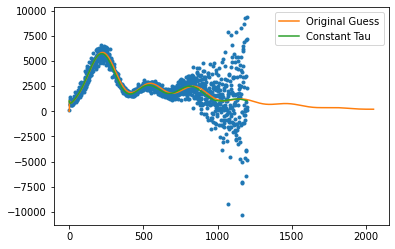

In [55]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=2000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    As=pars[3]
    ns=pars[4]
    tau=pars[5] #move tau to end of parameter list
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

def cmb_num_deriv(n,pars,dpar):
    #Calculate numerical derivative of cmb as a function of parameters
    derivs=np.zeros([n,len(pars)])
    for i in range(len(pars)):
        pars2=pars.copy()
        pars2[i]=pars2[i]+dpar[i]
        cmb_right=get_spectrum(pars2)
        pars2[i]=pars[i]-dpar[i]
        cmb_left=get_spectrum(pars2)
        derivs[:,i]=(cmb_right-cmb_left)/(2*dpar[i])
    return derivs

def our_chisq(data,pars):
    #Calculates chi^2 for wmap and cmb
    x=data[:,0]
    y=data[:,1]
    noise=data[:,2]
    model=get_spectrum(pars)[2:1201]
    chisq=np.sum((y-model)**2/noise**2)
    return chisq

#Set starting parameters and define data
pars=np.asarray([65,0.02,0.1,2e-9,0.96,0.05])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')
x=wmap[:,0]
y=wmap[:,1]
noise=wmap[:,2]
cmb=get_spectrum(pars)
n=len(cmb)

#Check derivative validity through plotting:
fig, axs = plt.subplots(6,figsize=(15,15))
dpar_test=np.zeros([20,6])
dpar_test[0,:]=[5,0.01,0.05,5e-10,0.5,0.01]
for i in range(5):
    derivs_test=cmb_num_deriv(n,pars,dpar_test[i,:])
    for j in range(len(pars)):
        axs[j].plot(derivs_test[:,j],label=dpar_test[i,j])
        axs[j].set_title(('Parameter value:',pars[j]))
        axs[j].legend()
    dpar_test[i+1,:]=dpar_test[i,:]/10
fig.suptitle('Parameter Numerical Derivatives with Decreasing Step Size')
plt.subplots_adjust(hspace=0.5)
plt.show()

#Define noise matrix, derivative steps, lambda, and tolerance for Newton's method.
Ninv=np.eye(len(x))/noise**2
dpar=np.asarray([1e-2,1e-5,1e-4,1e-14,1e-4,1e-5])
scale=0.0
tol=0.05
chisq=our_chisq(wmap,pars)

#Run Newton's Method with constant Tau
for i in range(20):
    model=get_spectrum(pars)[2:1201]
    derivs=cmb_num_deriv(n,pars,dpar)[2:1201]
    resid=y-model
    lhs=derivs.T@Ninv@derivs
    rhs=derivs.T@Ninv@resid
    #introduce scale factor (lambda)
    mat_scale=np.ones([len(pars),len(pars)])+np.eye(len(pars))*(scale)
    lhs=lhs*mat_scale
    #take step
    lhs_inv=np.linalg.inv(lhs)
    step=lhs_inv@rhs
    step[5]=0.0 #keep tau constant
    pars=pars+step
    #evaluate change in chi squared
    chisq2=our_chisq(wmap,pars)
    dchisq=chisq2-chisq
    print('\nChange in chi squared at iteration',i,'is',dchisq)
    #end loop if delta chi squared is less than tolerance
    if np.abs(dchisq)<=tol:
        print('Tolerance achieved.')
        break
    #decrease lambda if chi squared decreased, otherwise increase
    if dchisq<=0:
        scale=scale/np.sqrt(2)
        if scale<0.01: scale=0.0
    else:
        if scale==0: scale=1
        scale=scale*2
    chisq=chisq2

print('Final parameters with constant tau are: ',pars)
print('Final parameter steps were:',step)

pars_sigma=np.sqrt(np.diag(lhs_inv))
print('The error in the parameters is: ',pars_sigma)

plt.figure(1)
plt.ion()
plt.clf();
plt.plot(wmap[:,0],wmap[:,1],'.')
plt.plot(cmb,label='Original Guess')
plt.plot(model,label="Constant Tau")
plt.legend()
plt.show()

pars2=np.copy(pars)  #start with parameter results from  last fit.

#Covariance Matrix
derivs_final=cmb_num_deriv(n,pars,dpar)[2:1201]
lhs_final=derivs_final.T@Ninv@derivs_final
cov_mat=np.linalg.inv(lhs_final)



The derivatives for a given set of parameters do not change significantly as the step size is decreased past the first step. The second-to-last step size can thus safely be used to calculate the derivatives for each new set of parameters. 

I expect the fit errors would go down when tau is floated, as an extra degree of freedom should allow for a better fit. 



Problem 4 - MCMC 

30 2035 2040 2045 2050 2055 2060 2065 2070 2075 2080 2085 2090 2095 2100 2105 2110 2115 2120 2125 2130 2135 2140 2145 2150 2155 2160 2165 2170 2175 2180 2185 2190 2195 2200 2205 2210 2215 2220 2225 2230 2235 2240 2245 2250 2255 2260 2265 2270 2275 2280 2285 2290 2295 2300 2305 2310 2315 2320 2325 2330 2335 2340 2345 2350 2355 2360 2365 2370 2375 2380 2385 2390 2395 2400 2405 2410 2415 2420 2425 2430 2435 2440 2445 2450 2455 2460 2465 2470 2475 2480 2485 2490 2495 2500 2505 2510 2515 2520 2525 2530 2535 2540 2545 2550 2555 2560 2565 2570 2575 2580 2585 2590 2595 2600 2605 2610 2615 2620 2625 2630 2635 2640 2645 2650 2655 2660 2665 2670 2675 2680 2685 2690 2695 2700 2705 2710 2715 2720 2725 2730 2735 2740 2745 2750 2755 2760 2765 2770 2775 2780 2785 2790 2795 2800 2805 2810 2815 2820 2825 2830 2835 2840 2845 2850 2855 2860 2865 2870 2875 2880 2885 2890 2895 2900 2905 2910 2915 2920 2925 2930 2935 2940 2945 2950 2955 2960 2965 2970 2975 2980 2985 2990 2995 3000 3005 3010 3015 3020 3025 30

<Figure size 432x288 with 0 Axes>

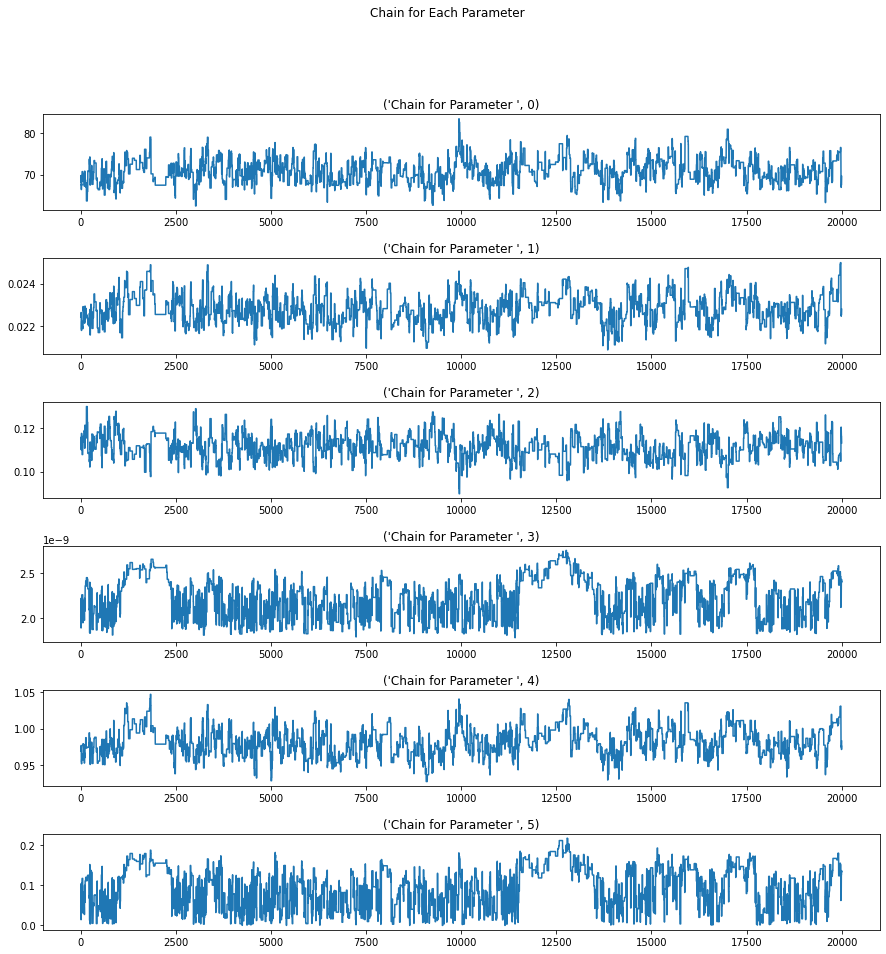


The final parameter values are :
[7.08560308e+01 2.28326075e-02 1.11433185e-01 2.22260466e-09
 9.81935482e-01 9.21778926e-02]
with errors 
[2.92788447e+00 6.77544780e-04 5.76498581e-03 2.25009267e-10
 1.94917856e-02 5.16408053e-02]


<Figure size 432x288 with 0 Axes>

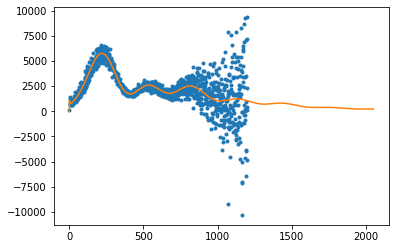

In [6]:
covMat=cov_mat #covariance matrix from Newton's method
pars3=pars2 #last parameters from Newton's method as starting point
wmap=wmap #same data
x=wmap[:,0]
y=wmap[:,1]
noise=wmap[:,2]

def run_chain_corr(pars,chifun,data,corr_mat,nsamp=20000):
    npar=len(pars)
    chain=np.zeros([nsamp,npar])
    chivec=np.zeros(nsamp)
    chisq=chifun(data,pars)
    L=np.linalg.cholesky(corr_mat)
    count=0
    count_accepted=0
    print('Current Iteration:')
    for i in range(nsamp):
        pars_trial=pars+L@np.random.randn(npar)
        chi_new=chifun(data,pars_trial)
        delta_chi=chi_new-chisq
        if np.random.rand(1)<np.exp(-0.5*delta_chi) and pars_trial[5]>=0:
            chisq=chi_new
            pars=pars_trial
            count_accepted=count_accepted+1
        chain[i,:]=pars
        chivec[i]=chisq
        count=count+1
        if i%5==0: print(i,end=' ') #print iteration at regular intervals to see how far code has gotten
    acceptance_rate=(count_accepted*1.0)/count
    print('\nThe acceptance rate was',acceptance_rate)
    return chain,chivec


chain,chivec=run_chain_corr(pars3,our_chisq,wmap,covMat,nsamp=20000)

plt.clf();
fig, axs = plt.subplots(6,figsize=(15,15))
for j in range(len(pars3)):
    axs[j].plot(chain[:,j])
    axs[j].set_title(('Chain for Parameter ',j))
fig.suptitle('Chain for Each Parameter')
plt.subplots_adjust(hspace=0.5)
plt.show()
plt.savefig('MCMCChain1.png')

print('\nThe final parameter values are :')
pars_final3=np.mean(chain,axis=0)
print(pars_final3)
print('with errors ')
pars_sigs3=np.std(chain,axis=0)
print(pars_sigs3)

cmb_final3=get_spectrum(pars_final3)
plt.figure(3)
plt.clf();
plt.plot(x,y,'.')
plt.plot(cmb_final3)
plt.show()

np.savetxt('wmapChain1.txt',chain)


Visually, the chains look relatively converged, but the acceptance rate is much lower than expected (only around 8% rather than 25%).From the corner plot below, it also does not look to be very converged, as there are pretty clear covariances remaining between parameters. The errors in the parameters are also larger than I would expect from a converged chain. 

The low acceptance rate could be related to the fact that I counted steps with a negative tau value as rejected. In addition, I believe my covariance matrix might not have been completely correct: in setting the step size for tau to 0.0 manually in the Newton's Method, I think I may have introduced additional error through the unnecessary derivative calculations which went into the covariance matrix. In addition, I believe the chain may not be well-converged due to the derivative step sizes I chose for the derivatives in problem 3. Unfortunately, my chain took so long to run (c. 10 hours) that I was unable to really tweak these values. 

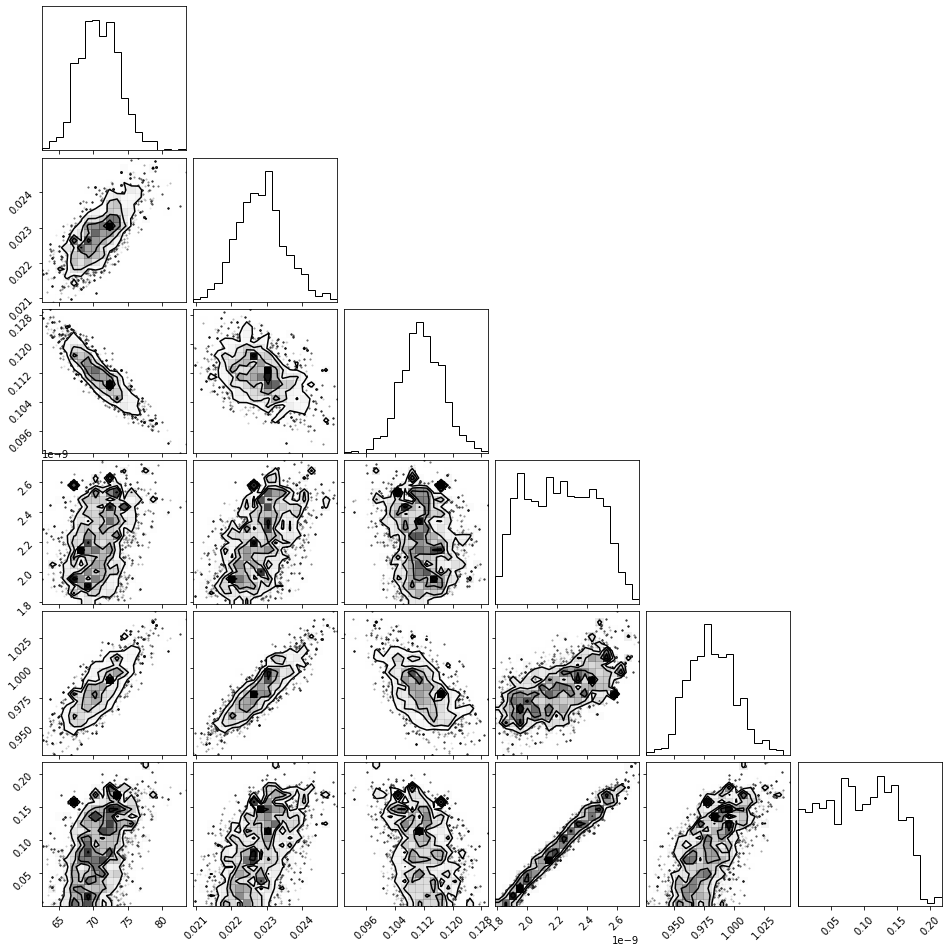

In [26]:
import corner 
cornerTest=corner.corner(chain)



Problem 5 - Prior Tau Value

In [39]:
#Importance Sampling

#Get chain from first MCMC
chain_sample=np.copy(chain)

#Calculate Weight
dchiw=((0.0544-chain_sample[:,5])/0.0073)**2
weight=np.exp(-0.5*dchiw)

#Find parameter means and errors
sample_scat=np.copy(chain)
sample_means=np.zeros(chain_sample.shape[1])
sample_errors=np.zeros(chain_sample.shape[1])
for i in range(chain_sample.shape[1]):
    sample_means[i]=np.sum(weight*chain_sample[:,i])/np.sum(weight)
    sample_scat[:,i]=sample_scat[:,i]-sample_means[i]
    sample_errors[i]=np.sqrt(np.sum(sample_scat[:,i]**2*weight)/np.sum(weight))

print('The importance sampled parameter means are,')
print(sample_means)
print('The importance sampled parameter errors are,')
print(sample_errors)

The importance sampled parameter means are,
[6.99155239e+01 2.25684641e-02 1.12892490e-01 2.05698697e-09
 9.73049342e-01 5.43477518e-02]
The importance sampled parameter errors are,
[2.33597448e+00 5.77606840e-04 5.24429683e-03 5.33249534e-11
 1.37759114e-02 7.69912065e-03]


0 2035 2040 2045 2050 2055 2060 2065 2070 2075 2080 2085 2090 2095 2100 2105 2110 2115 2120 2125 2130 2135 2140 2145 2150 2155 2160 2165 2170 2175 2180 2185 2190 2195 2200 2205 2210 2215 2220 2225 2230 2235 2240 2245 2250 2255 2260 2265 2270 2275 2280 2285 2290 2295 2300 2305 2310 2315 2320 2325 2330 2335 2340 2345 2350 2355 2360 2365 2370 2375 2380 2385 2390 2395 2400 2405 2410 2415 2420 2425 2430 2435 2440 2445 2450 2455 2460 2465 2470 2475 2480 2485 2490 2495 2500 2505 2510 2515 2520 2525 2530 2535 2540 2545 2550 2555 2560 2565 2570 2575 2580 2585 2590 2595 2600 2605 2610 2615 2620 2625 2630 2635 2640 2645 2650 2655 2660 2665 2670 2675 2680 2685 2690 2695 2700 2705 2710 2715 2720 2725 2730 2735 2740 2745 2750 2755 2760 2765 2770 2775 2780 2785 2790 2795 2800 2805 2810 2815 2820 2825 2830 2835 2840 2845 2850 2855 2860 2865 2870 2875 2880 2885 2890 2895 2900 2905 2910 2915 2920 2925 2930 2935 2940 2945 2950 2955 2960 2965 2970 2975 2980 2985 2990 2995 3000 3005 3010 3015 3020 3025 303

<Figure size 432x288 with 0 Axes>

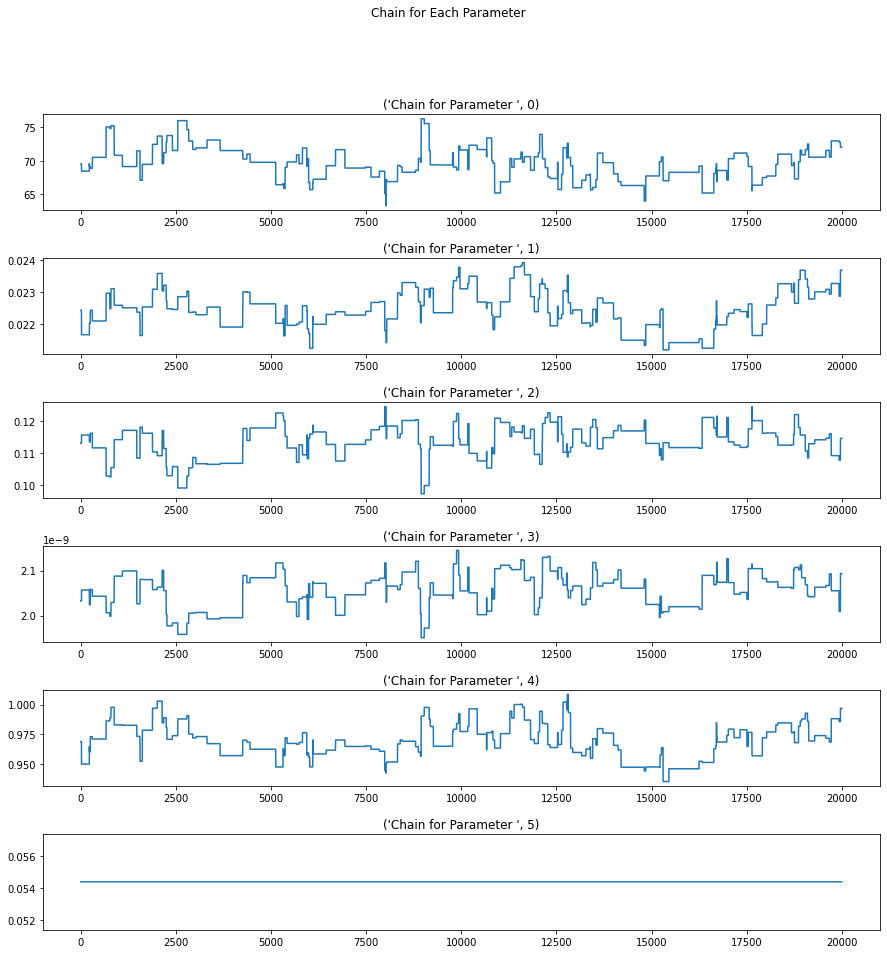


The final parameter values are :
[6.96126092e+01 2.24433290e-02 1.13514950e-01 2.05554305e-09
 9.69064361e-01 5.44000000e-02]
with errors 
[2.34961486e+00 5.98305280e-04 4.97383038e-03 3.82567776e-11
 1.42174765e-02 1.14352972e-14]


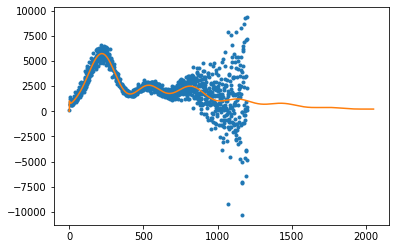

In [42]:
covMat5=np.copy(cov_mat) #covariance matrix from Newton's method
pars5=np.copy(pars2) #last parameters from Newton's method as starting point
pars5[5]=0.0544 #prior
wmap=np.copy(wmap) #same data
x=wmap[:,0]
y=wmap[:,1]
noise=wmap[:,2]

def run_chain_corr(pars,chifun,data,corr_mat,nsamp=20000):
    npar=len(pars)
    chain=np.zeros([nsamp,npar])
    chivec=np.zeros(nsamp)
    chisq=chifun(data,pars)
    L=np.linalg.cholesky(corr_mat)
    count=0
    count_accepted=0
    print('Current Iteration:')
    for i in range(nsamp):
        pars_trial=pars+L@np.random.randn(npar)
        pars_trial[5]=0.0544 #keep tau constant at prior value
        chi_new=chifun(data,pars_trial)
        delta_chi=chi_new-chisq
        if np.random.rand(1)<np.exp(-0.5*delta_chi):
            chisq=chi_new
            pars=pars_trial
            count_accepted=count_accepted+1
        chain[i,:]=pars
        chivec[i]=chisq
        count=count+1
        if i%5==0: print(i,end=' ')
    acceptance_rate=(count_accepted*1.0)/count
    print('\nThe acceptance rate was',acceptance_rate)
    return chain,chivec


chain5,chivec5=run_chain_corr(pars5,our_chisq,wmap,covMat5,nsamp=20000)

plt.clf();
fig, axs = plt.subplots(6,figsize=(15,15))
for j in range(len(pars5)):
    axs[j].plot(chain5[:,j])
    axs[j].set_title(('Chain for Parameter ',j))
fig.suptitle('Chain for Each Parameter')
plt.subplots_adjust(hspace=0.5)
plt.show()

print('\nThe final parameter values are :')
pars_final5=np.mean(chain5,axis=0)
print(pars_final5)
print('with errors ')
pars_sigs5=np.std(chain5,axis=0)
print(pars_sigs5)

cmb_final5=get_spectrum(pars_final5)
plt.figure(3)
plt.clf();
plt.plot(x,y,'.')
plt.plot(cmb_final5)
plt.show()

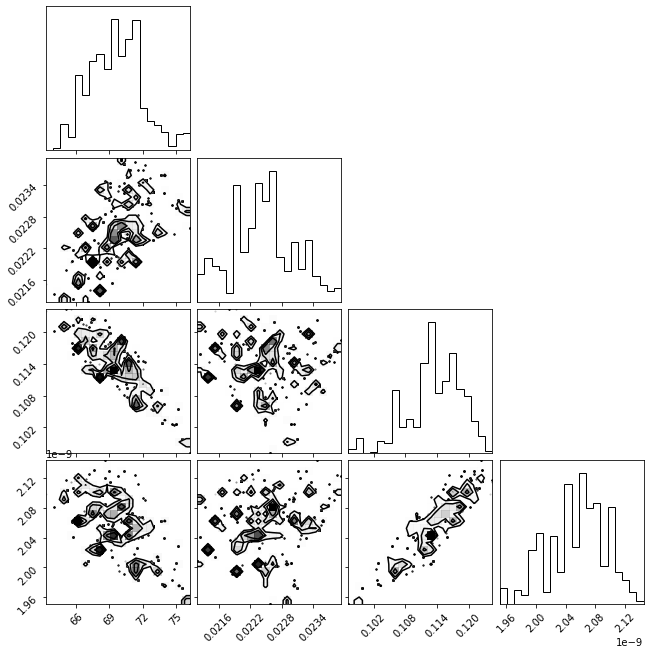

In [48]:
np.savetxt('PriorChainWMB.txt',chain5)
corner_prior=corner.corner(chain5[:,:4])

This chain is pretty clearly not converged, which could likely be resolved with additional samples, but the code runs prohibitively slowly (12 hours), making it unrealistic to run a longer chain. The lack of correlation is likely due to the fact that there are fewer degrees of freedom (as Tau is constant) and that more steps outside of the prior range are being rejected. However, the actual resulting parameter values match very closely with the importance sampled chain, especially the tau value which was far from the prior value in the original (unweighted) chain. In addition, the errors in the parameter values for this new chain are lower than those from the old chain, indicating that despite the lack of convergence the fit is improved by including the Planck prior value. 